# The Gaussian Mixture Model and EM-algorithm

A <b>Gaussian mixture model</b> is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. [http://scikit-learn.org]

The <b>Expectation-Maximization algorithm</b>, or <b>EM algorithm</b>, is a general technique for finding maximum likelihood solutions for probabilistic models having latent variables. (Dempster et al., 1977; McLachlan and Krishnan, 1997). The EM algorithm breaks down the potentially difficult problem of maximizing the likelihood function into two stages, the E step (which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters) and the M step (which computes parameters maximizing the expected log-likelihood found on the E step).

We will implement Expectation-Maximization algorithm for learning and inference in a Gaussian mixture model. We will use the [dataset](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) containing information about eruptions of a geyser called "Old Faithful".

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from scipy.stats import multivariate_normal

## Generating and visualizing the data

The dataset contains a record of the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. A data frame with 272 observations on these 2 variables. At the first sight, we can see that the longer we wait for an eruption, the longer the eruption itself is going to be.

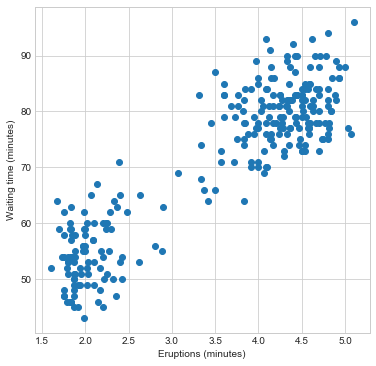

In [10]:
X = np.loadtxt('Old Faithful geyser.txt')
plt.figure(figsize=[6, 6])
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Eruptions (minutes)')
plt.ylabel('Waiting time (minutes)')
plt.show()

## Normalizing the data

Machine learning alogorithms work well with normalized data. Moreover, in this data set the scaling of the two features is very different. We normalize the data so that it lies betwee 0 and 1 along each dimension. 

In [11]:
def normalize_data(X):
    
    X_norm = np.zeros(X.shape)
    X_norm[:,0] = (X[:,0] - np.amin(X[:,0]))/(np.amax(X[:,0]) - np.amin(X[:,0]))
    X_norm[:,1] = (X[:,1] - np.amin(X[:,1]))/(np.amax(X[:,1]) - np.amin(X[:,1]))

    return X_norm

### Plot the normalized data

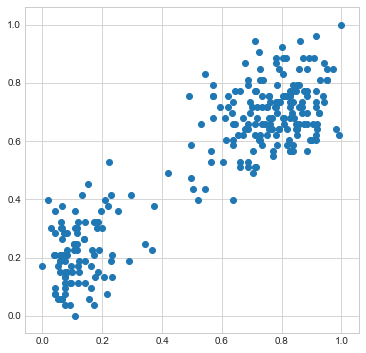

In [12]:
plt.figure(figsize=[6, 6])
X_norm = normalize_data(X)
plt.scatter(X_norm[:, 0], X_norm[:, 1]);

## The log-likelihood of GMM


<b>Parameters</b>:<br/>
 <i>X</i> : array, shape [N, D] (Data matrix with samples as rows)<br/>
 <i>means</i> : array, shape [K, D] (Means of the GMM)<br/>
 <i>covs</i>: array, shape [K, D, D] (Covariance matrices of the GMM)<br/>
 <i>mixing_coefs</i> : array, shape [K] (Mixing proportions of the GMM)<br/>
<b>Return</b>: <br/>
<i>log_likelihood</i>: float (Log-likelihood of the data under the given GMM)

In [15]:
def gmm_log_likelihood(X, means, covs, mixing_coefs):
    
    sum2 = 0
    for i in range(X.shape[0]):
        sum1 = 0
        for k in range(mixing_coefs.shape[0]):
            sum1 += mixing_coefs[k] * multivariate_normal.pdf(X[i], mean=means[k], cov=covs[k])
        sum2 += np.log(sum1)
    log_likelihood = sum2
    
    return log_likelihood

## E step
E-step is about "calculating the responsibilities of Gaussians for creating the given training data point"

<b>Parameters</b>:<br/>
 <i>X</i> : array, shape [N, D] (Data matrix with samples as rows)<br/>
 <i>means</i> : array, shape [K, D] (Means of the GMM)<br/>
 <i>covs</i>: array, shape [K, D, D] (Covariance matrices of the GMM)<br/>
 <i>mixing_coefs</i> : array, shape [K] (Mixing proportions of the GMM)<br/>
<b>Return</b>: <br/>
<i>responsibilities</i>: array, shape [N, K] (Cluster responsibilities for the given data)

In [16]:
def e_step(X, means, covs, mixing_coefs):
    
    responsibilities = np.zeros((X.shape[0],means.shape[0]))
    num = np.zeros(mixing_coefs.shape[0])
    denomin=0
    for n in range(X.shape[0]):
        denomin = 0
        for k in range(mixing_coefs.shape[0]):
            num[k] = mixing_coefs[k] * multivariate_normal.pdf(X[n,:], means[k,:],covs[k,:,:])
            denomin += mixing_coefs[k] * multivariate_normal.pdf(X[n,:], means[k,:],covs[k,:,:])
        for k in range(mixing_coefs.shape[0]):
            responsibilities[n,k] = num[k] / denomin
            
    return responsibilities


## M step

Given the responsibilities, we update the parameters of Gaussians - the means, covariance matrices and mixing coeeficients.

<b>Parameters</b>:<br/>
<i>responsibilities</i>: array, shape [N, K] (Cluster responsibilities for the given data)<br/>
<i>X</i> : array, shape [N, D] (Data matrix with samples as rows) <br/>
<b>Return</b>: <br/>
<i>means</i>: array, shape [K, D] (Means of the latent Gaussians)<br/>
<i>covs</i>: array, shape [K, D, D] (Covariance matrices of the latent Gaussians)<br/>
<i>mixing_coefs</i>: np.array, shape [K] (Mixing proportions of the GMM)


In [17]:
def m_step(X, responsibilities):

    N = np.zeros(responsibilities.shape[1])
    #iterate over clusters
    for k in range(responsibilities.shape[1]):
        #init
        N[k] = responsibilities[:,k].sum(axis=0)
        sum_mean = 0
        sum_cov = 0
        #new means
        for i in range(X.shape[0]):
            sum_mean += responsibilities[i,k] * X[i, :]
        sum_mean /= N[k]
        #new covs
        for i in range(X.shape[0]):
            A = X[i, :] - sum_mean
            sum_cov += responsibilities[i,k] *np.outer(A, A.T)
        means[k,:] = sum_mean
        covs[k,:,:] = sum_cov / N[k]
    NN = N.sum(axis=0)
    mixing_coefs = N / NN
    
    return means, covs, mixing_coefs

## Visualize the result 
We visualize a mixture of 2 bivariate Gaussians.

In [18]:
def plot_gmm_2d(X, responsibilities, means, covs, mixing_coefs):

    plt.figure(figsize=[6, 6])
    palette = np.array(sns.color_palette('colorblind', n_colors=3))[[0, 2]]
    colors = responsibilities.dot(palette)
    # Plot the samples colored according to p(z|x)
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
    # Plot locations of the means
    for ix, m in enumerate(means):
        plt.scatter(m[0], m[1], s=300, marker='X', c=palette[ix],
                    edgecolors='k', linewidths=1,)
    # Plot contours of the Gaussian
    x = np.linspace(0, 1, 50)
    y = np.linspace(0, 1, 50)
    xx, yy = np.meshgrid(x, y)
    for k in range(len(mixing_coefs)):
        zz = mlab.bivariate_normal(xx, yy, np.sqrt(covs[k][0, 0]),
                                   np.sqrt(covs[k][1, 1]), 
                                   means[k][0], means[k][1], covs[k][0, 1])
        plt.contour(xx, yy, zz, 2, colors='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

## Run the EM algorithm

At initialization: log-likelihood = -382.70551524206564


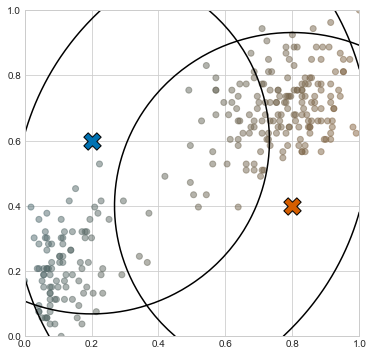

Iteration 0: log-likelihood = 131.29, improvement = 513.99


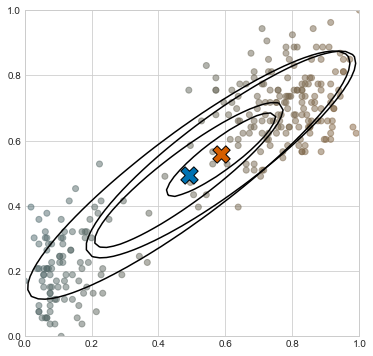

Iteration 1: log-likelihood = 131.48, improvement = 0.19


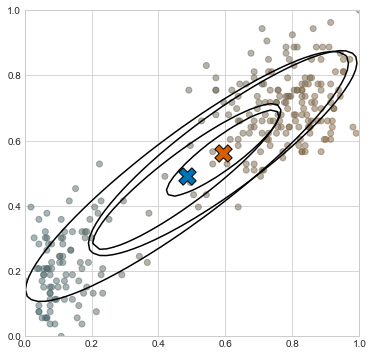

Iteration 2: log-likelihood = 131.75, improvement = 0.27


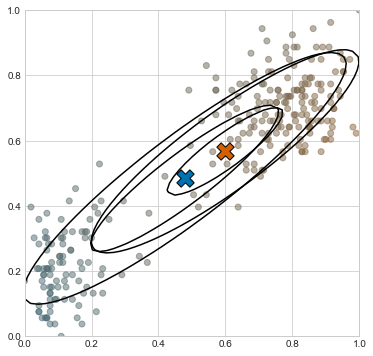

Iteration 3: log-likelihood = 132.15, improvement = 0.40


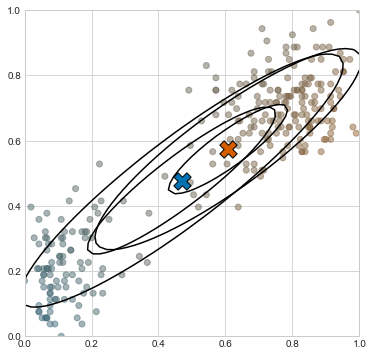

Iteration 4: log-likelihood = 132.77, improvement = 0.62


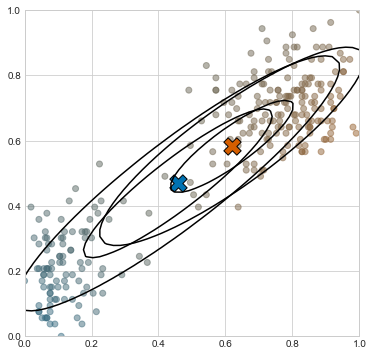

Iteration 5: log-likelihood = 133.81, improvement = 1.04


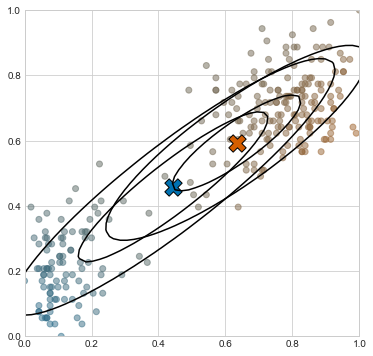

Iteration 6: log-likelihood = 135.74, improvement = 1.93


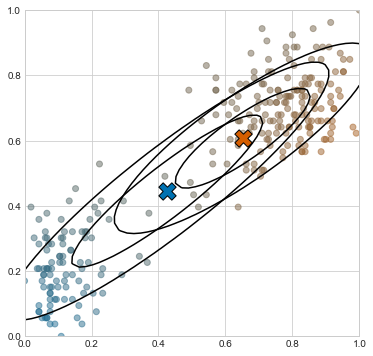

Iteration 7: log-likelihood = 139.88, improvement = 4.14


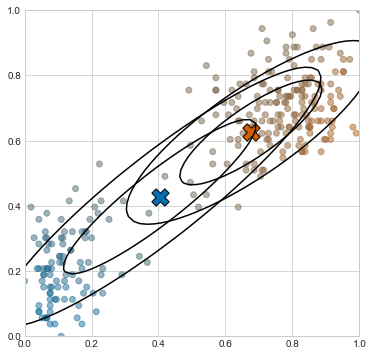

Iteration 8: log-likelihood = 150.67, improvement = 10.79


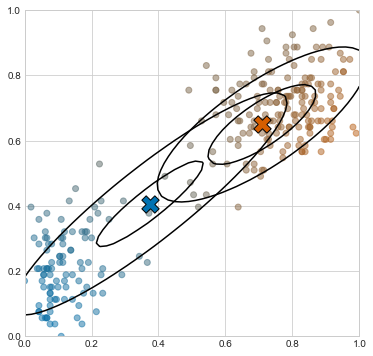

Iteration 9: log-likelihood = 181.12, improvement = 30.45


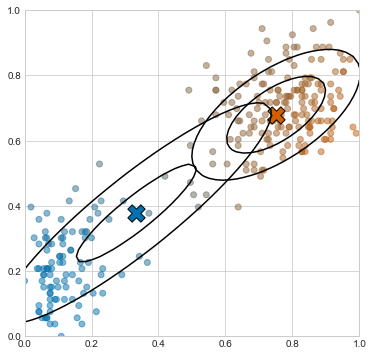

Iteration 10: log-likelihood = 220.93, improvement = 39.81


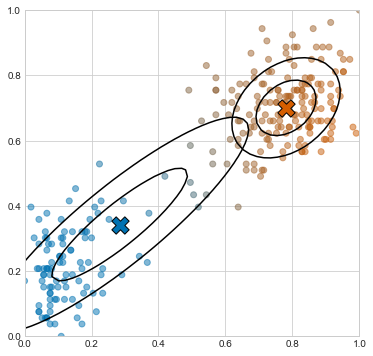

Iteration 11: log-likelihood = 234.06, improvement = 13.14


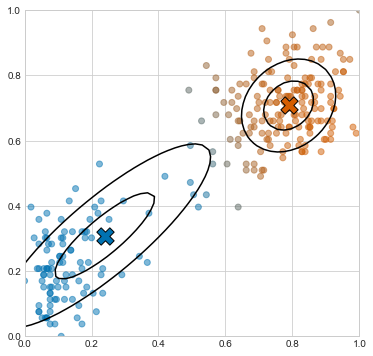

Iteration 12: log-likelihood = 244.83, improvement = 10.77


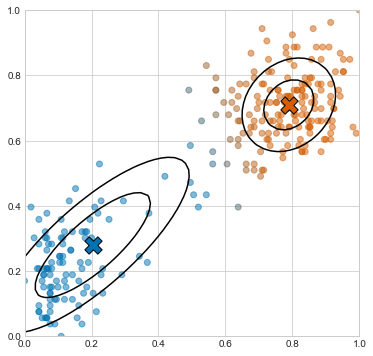

Iteration 13: log-likelihood = 258.67, improvement = 13.84


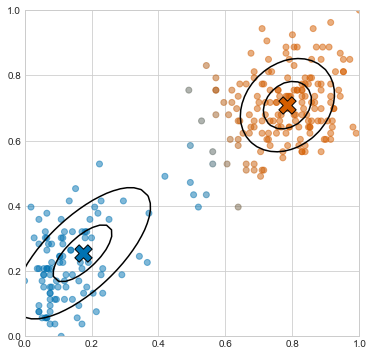

Iteration 14: log-likelihood = 272.91, improvement = 14.23


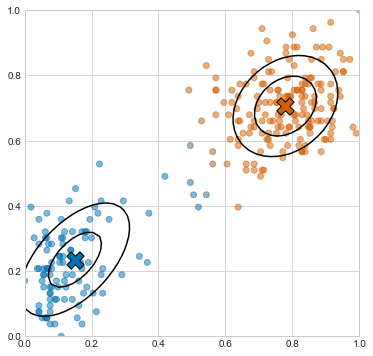

Iteration 15: log-likelihood = 284.29, improvement = 11.38


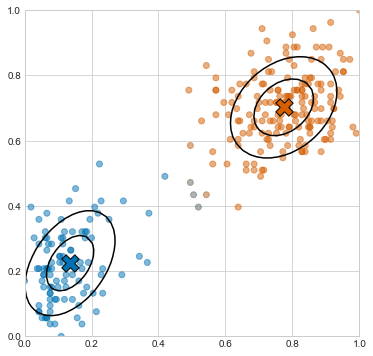

Iteration 16: log-likelihood = 289.94, improvement = 5.65


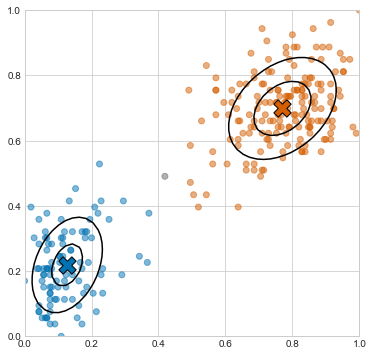

Iteration 17: log-likelihood = 290.39, improvement = 0.45


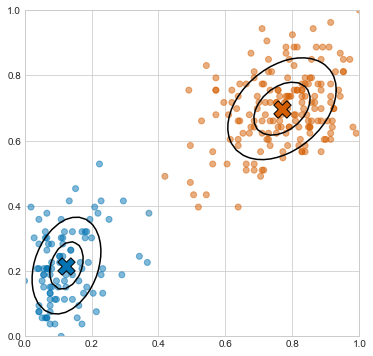

Iteration 18: log-likelihood = 290.41, improvement = 0.01


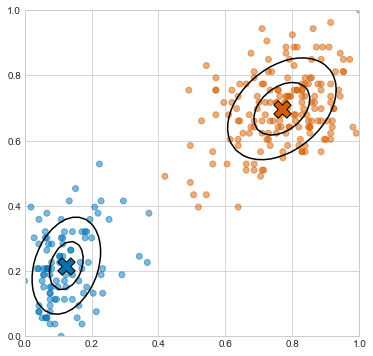

Iteration 19: log-likelihood = 290.41, improvement = 0.00


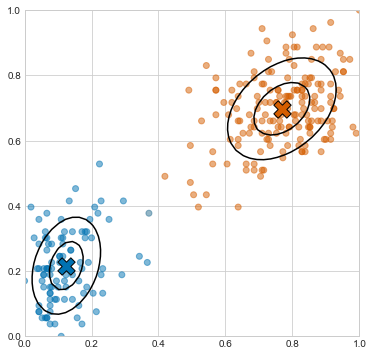

In [19]:
X_norm = normalize_data(X)
max_iters = 20

# Initialize the parameters
means = np.array([[0.2, 0.6], [0.8, 0.4]])
covs = np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
mixing_coefs = np.array([0.5, 0.5])

old_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
responsibilities = e_step(X_norm, means, covs, mixing_coefs)
print('At initialization: log-likelihood = {0}'
      .format(old_log_likelihood))
plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)

# Perform the EM iteration
for i in range(max_iters):
    responsibilities = e_step(X_norm, means, covs, mixing_coefs)
    means, covs, mixing_coefs = m_step(X_norm, responsibilities)
    new_log_likelihood = gmm_log_likelihood(X_norm, means, covs, mixing_coefs)
    # Report & visualize the optimization progress
    print('Iteration {0}: log-likelihood = {1:.2f}, improvement = {2:.2f}'
          .format(i, new_log_likelihood, new_log_likelihood - old_log_likelihood))
    old_log_likelihood = new_log_likelihood
    plot_gmm_2d(X_norm, responsibilities, means, covs, mixing_coefs)